# Figure 3

In [1]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
import pyvis as pv
from pyvis.network import Network
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures4/correlation_clustering.py'>

In [2]:
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/regulatory_data/regulatory_data_IMR90/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_regulatory_marks/processed_epigenome_data_IMR90/'
# Directory of TF data
dir_htftarget = '/home/louiscam/projects/gpcr/data/tf_data/hTFtarget/'
# Directory of TCR data
dir_tcr = '/home/louiscam/projects/gpcr/data/tcr_data/'
# Directory of proteins of interest
dir_proteins = '/home/louiscam/projects/gpcr/data/protein_families/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

# RNAseq directory
dir_rna = '/home/louiscam/projects/gpcr/data/bulk_rnaseq/'

In [3]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Load gene data

In [4]:
# Gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)
df_loc['geneLength'] = df_loc['chromEnd']-df_loc['chromStart']
genes_df = df_loc[['geneSymbol', 'geneLength']].set_index('geneSymbol')

In [5]:
# Active/inactive loci
with open(saving_dir+'all_active_loci.pkl', 'rb') as f:
    all_active_loci = pickle.load(f)
with open(saving_dir+'all_inactive_loci.pkl', 'rb') as f:
    all_inactive_loci = pickle.load(f)
    
# Active/inactive genes
with open(saving_dir+'active_genes.pkl', 'rb') as f:
    active_genes = pickle.load(f)
with open(saving_dir+'inactive_genes.pkl', 'rb') as f:
    inactive_genes = pickle.load(f)

In [6]:
# Adhesome genes
with open(saving_dir+'active_adhesome_loci.pkl', 'rb') as f:
    active_adhesome_loci = pickle.load(f)
with open(saving_dir+'inactive_adhesome_loci.pkl', 'rb') as f:
    inactive_adhesome_loci = pickle.load(f)
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
with open(saving_dir+'inactive_adhesome_genes.pkl', 'rb') as f:
    inactive_adhesome_genes = pickle.load(f)
with open(saving_dir+'adhesome_chr_loci.pkl', 'rb') as f:
    adhesome_chr_loci = pickle.load(f)
all_adhesome_genes = np.concatenate([active_adhesome_genes,inactive_adhesome_genes])

In [7]:
# TF genes
with open(saving_dir+'active_lung_adhesome_tf_genes.pkl', 'rb') as f:
    active_lung_adhesome_tf_genes = pickle.load(f)

In [8]:
# Mapping gene to chromosome
with open(saving_dir+'gene2chrom.pkl', 'rb') as f:
    gene2chrom = pickle.load(f)

# Load TF data

In [9]:
# Load data
htargettf_df = pd.read_csv(dir_htftarget+'hTFtarget.txt', sep='\t', header=0)
htargettf_df['adhesome target'] = htargettf_df['target'].isin(all_adhesome_genes)
htargettf_df['lung'] = htargettf_df['tissue'].str.contains('lung')
htargettf_df = htargettf_df[['TF','target','adhesome target','tissue','lung']]
lung_tfs = htargettf_df[htargettf_df['lung']==True]['TF'].unique()
print('Number of unique TFs = '+str(len(np.unique(htargettf_df['TF']))))
print('Number of unique targets = '+str(len(np.unique(htargettf_df['target']))))
print('Number of TF-target links = '+str(len(htargettf_df)))

Number of unique TFs = 495
Number of unique targets = 38183
Number of TF-target links = 1342129


In [10]:
# Import tissue composition for all the tissues in hTFtarget
tf_metadata_df = pd.read_csv(dir_htftarget+'htftarget_metadata.csv', header=0, index_col=0, sep='\t')

# Number of interactions involving adhesome genes in all tissues

In [12]:
# Create data frame of TF-target in all tissues
htargettf_df2 = htargettf_df.copy()
htargettf_df2['tissue'] = htargettf_df2['tissue'].str.lower()
htargettf_df2['tissue'] = htargettf_df2['tissue'].str.split(',')
htargettf_df2 = lu.unnesting(htargettf_df2, ['tissue'])
htargettf_df2 = htargettf_df2[(htargettf_df2['tissue']!='unclear') & 
                              (htargettf_df2['tissue']!='unknown') & 
                              (htargettf_df2['tissue']!='other')]
htargettf_df2.head()

,tissue,TF,target,adhesome target,lung
0,colon,AEBP2,TMEM53,False,False
1,colon,AEBP2,C1orf228,False,False
2,colon,AEBP2,FBXO31,False,False
3,colon,AEBP2,ADAMTSL5,False,False
4,colon,AEBP2,CTB-25B13.9,False,False


In [13]:
# Compute number of genes targeted in all tissues
htargettf_df2_all = htargettf_df2.groupby('tissue')['target'].nunique()
htargettf_df2_all = htargettf_df2_all.reset_index()
htargettf_df2_all.columns = ['tissue', 'number of genes targeted']
htargettf_df2_all = htargettf_df2_all.set_index('tissue')
htargettf_df2_all = htargettf_df2_all.sort_values(by='number of genes targeted')

In [14]:
# Compute number of adhesome genes targeted in all tissues
htargettf_df2_adh = htargettf_df2[htargettf_df2['adhesome target']==True]
htargettf_df2_adh = htargettf_df2_adh.groupby('tissue')['target'].nunique()
htargettf_df2_adh = htargettf_df2_adh.reset_index()
htargettf_df2_adh.columns = ['tissue', 'number of adhesome genes targeted']
htargettf_df2_adh = htargettf_df2_adh.set_index('tissue')
htargettf_df2_adh = htargettf_df2_adh.sort_values(by='number of adhesome genes targeted')

In [15]:
# Join
targets_per_tissues = pd.concat([htargettf_df2_all, htargettf_df2_adh], axis=1)
targets_per_tissues = targets_per_tissues.fillna(0).astype(int)

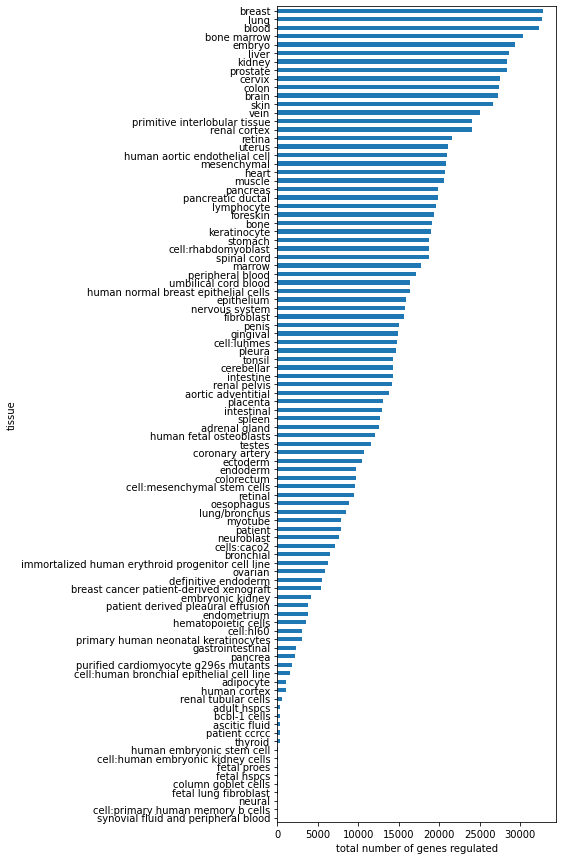

In [16]:
# Plot number of genes targeted for each tissue
plt.figure()
targets_per_tissues['number of genes targeted'].plot.barh(figsize=(5,15))
plt.xlabel('total number of genes regulated')
plt.ylabel('tissue')
plt.show()

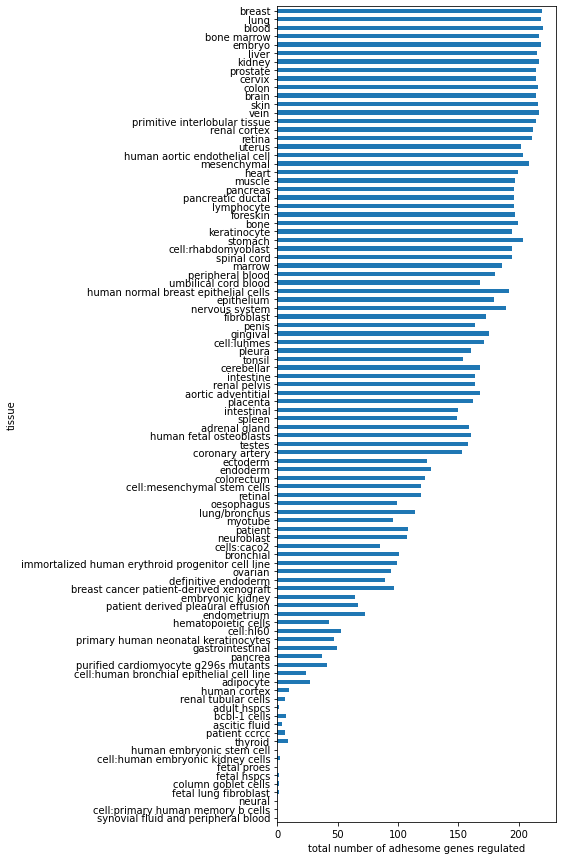

In [17]:
# Plot number of adhesome genes targeted for each tissue
plt.figure()
targets_per_tissues['number of adhesome genes targeted'].plot.barh(figsize=(5,15))
plt.xlabel('total number of adhesome genes regulated')
plt.ylabel('tissue')
plt.show()

# More details on breast, lung, blood

Breast, lung and blood are the tissues with the highest number of genes regulated, so we will use these three tissues when doing comparisons. It is important to understand what are the cell lines used for these tissues in hTFtarget, and whether these cell lines correspond to fibroblasts.

In [18]:
# Restrict data to tissues of interest
selected_metadata = tf_metadata_df[tf_metadata_df['tissue'].isin(['blood', 'breast','lung', 'bone marrow', 'embryo',
                                                                  'liver','kidney','prostate','colon',
                                                                  'brain', 'skin'])]
selected_metadata['fibroblast'] = selected_metadata['cell_type'].str.contains('fibrob')
selected_metadata['normal'] = selected_metadata['disease'].str.contains('norm')
selected_metadata['condition'] = ['fibroblast' if boolean==True else 'other' 
                                  for boolean in selected_metadata['fibroblast']]

In [19]:
selected_metadata[selected_metadata['tissue']=='blood'][['cell_type']].drop_duplicates().to_csv('tmp.csv')

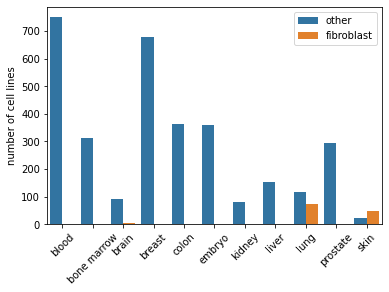

In [20]:
# Display number of fibroblast cell lines per tissue
plt.figure()
sns.barplot(data=selected_metadata.groupby(['tissue','condition'])['fibroblast'].count().reset_index(),
            x='tissue',y='fibroblast',hue='condition')
plt.xlabel('')
plt.ylabel('number of cell lines')
plt.xticks(rotation = 45)
plt.legend(loc='upper right')
plt.show()

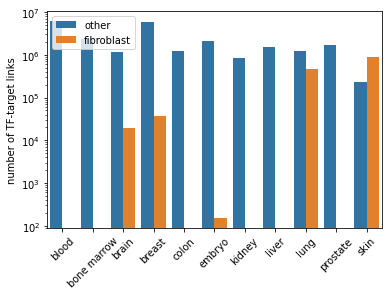

In [21]:
# Display number of TF-target links in fibroblast cell lines per tissue
plt.figure()
sns.barplot(data=selected_metadata.groupby(['tissue', 'condition'])['targets_count'].sum().reset_index(),
            x='tissue',y='targets_count',hue='condition')
plt.yscale('log')
plt.xlabel('')
plt.ylabel('number of TF-target links')
plt.xticks(rotation = 45)
plt.legend(loc='upper left')
plt.show()

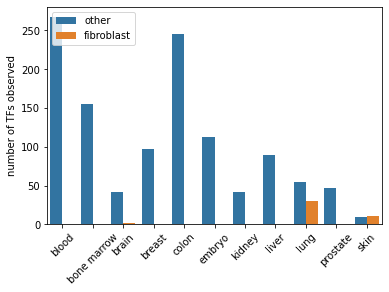

In [22]:
# Display number of TFs in cell lines per tissue
plt.figure()
sns.barplot(data=selected_metadata.groupby(['tissue', 'condition'])['factor'].nunique().reset_index(),
            x='tissue',y='factor',hue='condition')
plt.xlabel('')
plt.ylabel('number of TFs observed')
plt.xticks(rotation = 45)
plt.legend(loc='upper left')
plt.show()

In [22]:
# Save selected_metadata
selected_metadata.to_csv(dir_htftarget+'selected_data_to_scrape.csv')

In [40]:
x0 = htargettf_df[(htargettf_df['target'].isin(active_adhesome_genes)) &
                 (htargettf_df['lung']==True) &
                 (htargettf_df['TF'].isin(active_genes))]['TF'].unique()

In [42]:
len(x0)

47

In [39]:
x1 = tftarget_full_processed_data[(tftarget_full_processed_data['tissue'].str.contains('lung')) &
                             (tftarget_full_processed_data['target_gene'].isin(active_adhesome_genes)) &
                             (tftarget_full_processed_data['tf'].isin(active_genes))]['tf'].sort_values().unique()

In [41]:
len(x1)

56

In [43]:
set(x1)-set(x0)

{'BDP1',
 'BRF1',
 'BRF2',
 'NR3C1',
 'PIAS4',
 'SMAD4',
 'SNAPC2',
 'STAT3',
 'TP53',
 'UBE2I'}

In [44]:
set(x0)-set(x1)

{'JUN'}

In [59]:
tftarget_full_processed_data[(tftarget_full_processed_data['tf']=='JUN') &
                             (tftarget_full_processed_data['cell_line']=='Calu-3')]['target_id'].nunique()

460

In [64]:
np.sort(tftarget_full_processed_data[tftarget_full_processed_data['cell_line']=='Calu-3']['tf'].unique())

array(['EHF'], dtype=object)

# More details on lung fibroblasts

In [23]:
# Load full fibroblasts processed data
tftarget_full_processed_data = pd.read_csv(dir_htftarget+'tftarget_full_processed_data_new.csv', 
                                           sep='\t', header=0, index_col=0, low_memory=False)
tftarget_full_processed_data = tftarget_full_processed_data.dropna(subset=['target_gene'])

In [24]:
# Select only IMR90 cells
tftarget_imr90 = tftarget_full_processed_data[tftarget_full_processed_data['tissue']=='lung']
tftarget_imr90['adhesome_target'] = tftarget_imr90['target_gene'].isin(all_adhesome_genes)
tftarget_imr90['active_adhesome_target'] = tftarget_imr90['target_gene'].isin(active_adhesome_genes)

In [25]:
# Select only adhesome TFs
tftarget_imr90_adhesome = tftarget_imr90[tftarget_imr90['adhesome_target']==True]
active_adh_tfs = tftarget_imr90_adhesome[tftarget_imr90_adhesome['active_adhesome_target']==True]['tf'].unique()
n0 = tftarget_imr90['tf'].nunique()
n1 = tftarget_imr90_adhesome['tf'].nunique()
n2 = tftarget_imr90_adhesome[tftarget_imr90_adhesome['active_adhesome_target']==True]['tf'].nunique()
n3 = tftarget_imr90_adhesome['target_gene'].nunique()
n4 = tftarget_imr90_adhesome[tftarget_imr90_adhesome['active_adhesome_target']==True]['target_gene'].nunique()
print(f'Number of unique TFs that are in IMR90 = {n0}')
print(f'Number of unique TFs targeting adhesome genes = {n1}')
print(f'Number of unique TFs targeting active adhesome genes = {n2}')
print(f'Number of adhesome genes targeted = {n3}')
print(f'Number of active adhesome genes targeted = {n4}')
print('List of TFs targeting active adhesome genes:')
print(active_adh_tfs)

Number of unique TFs that are in IMR90 = 73
Number of unique TFs targeting adhesome genes = 71
Number of unique TFs targeting active adhesome genes = 71
Number of adhesome genes targeted = 222
Number of active adhesome genes targeted = 196
List of TFs targeting active adhesome genes:
['GABPA' 'RBL2' 'MAFK' 'BRF2' 'SMAD3' 'SPI1' 'CTCF' 'RB1' 'CREB1' 'TAF1'
 'NKX2-1' 'NEUROD1' 'FOXA2' 'E2F7' 'NR3C1' 'TP63' 'CHD1' 'CEBPB' 'EP300'
 'POLR2A' 'SUMO2' 'BHLHE40' 'PIAS4' 'RAD21' 'SMAD4' 'TCF12' 'MED1' 'HSF1'
 'SUMO1' 'FOSL2' 'ZBTB33' 'EHF' 'TEAD4' 'GTF2B' 'BRCA1' 'FOXA1' 'MYC'
 'BCL3' 'ETS1' 'SNAPC2' 'RFX5' 'ELF1' 'ASCL1' 'REST' 'STAT3' 'SOX2' 'BDP1'
 'MAX' 'RCOR1' 'TP53' 'PBX3' 'USF1' 'SP1' 'JUND' 'YY1' 'GATA3' 'BRD4'
 'RBL1' 'LMNB1' 'SIN3A' 'E2F6' 'SNAPC4' 'RELA' 'SIX5' 'BRF1' 'SMC1A'
 'MXI1' 'MAZ' 'UBE2I' 'ATF3' 'POU5F1']


In [26]:
set(active_adh_tfs).intersection(set(active_genes))-set(active_lung_adhesome_tf_genes)

{'BDP1',
 'BRF1',
 'BRF2',
 'NR3C1',
 'PIAS4',
 'SMAD4',
 'SNAPC2',
 'STAT3',
 'TP53',
 'UBE2I'}

In [102]:
# Active and inactive selected TFs
print('Adhesome TFs present in IMR90= '+str(active_adh_tfs))
print('Active adhesome TFs present in IMR90 = '+str(set(active_adh_tfs).intersection(active_genes)))
print('Inactive adhesome TFs present in IMR90 = '+str(set(active_adh_tfs).intersection(inactive_genes)))


Adhesome TFs present in IMR90= ['RBL2' 'MAFK' 'BRF2' 'RB1' 'E2F7' 'CHD1' 'EP300' 'GTF2B' 'BRCA1' 'SNAPC2'
 'RFX5' 'BDP1' 'RCOR1' 'TP53' 'CEBPB' 'RAD21' 'POLR2A' 'RBL1' 'LMNB1'
 'SNAPC4' 'BRF1' 'CTCF' 'MXI1' 'MAZ' 'SPI1']
Active adhesome TFs present in IMR90 = {'RCOR1', 'GTF2B', 'MAFK', 'E2F7', 'BRF1', 'CTCF', 'MXI1', 'BRCA1', 'CEBPB', 'SPI1', 'RFX5', 'MAZ', 'POLR2A', 'RAD21', 'BDP1', 'RBL2', 'TP53', 'RB1', 'RBL1', 'LMNB1', 'SNAPC2', 'BRF2'}
Inactive adhesome TFs present in IMR90 = {'SNAPC4', 'CHD1', 'EP300'}
